In [1]:
import pandas as pd
from fuzzywuzzy import process
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the dataset
df = pd.read_csv("C:/Users/Baba/Downloads/Capstone/reviews_feb_2023.csv", encoding='ISO-8859-1')

# Check for null values and data types
print(df.isna().sum()) 
print(df.dtypes)

# Replace null values
df['with_milk'] = df['with_milk'].fillna(0)

# Splitting and correcting locations
split_origin = df['coffee_origin'].str.split(',', expand=True)
split_roaster = df['roaster_location'].str.split(',', expand=True)

df['Coffee_Origin_Province'] = split_origin[0]
df['Coffee_Origin_Country'] = split_origin[1]
df['Roaster_Province'] = split_roaster[0]
df['Roaster_Country'] = split_roaster[1]

# Function to replace matches using fuzzy string matching (super heavy code need to be optimized by some other way)
def replace_matches_in_column(df, column, min_ratio=90):
    unique_values = df[column].astype(str).unique()
    # Optimization could be done here depending on the dataset characteristics

    for value in unique_values:
        matches = process.extract(value, unique_values, limit=10, scorer=process.fuzz.token_sort_ratio)
        close_matches = [match[0] for match in matches if match[1] >= min_ratio]

        if close_matches:
            df[column].replace(close_matches, value, inplace=True)

# Replace matches
replace_matches_in_column(df, "Coffee_Origin_Country")
replace_matches_in_column(df, "Coffee_Origin_Province")

# Replace region names with country names
region_to_country = {
    'southern Ethiopia': 'Ethiopia',
    'south-central Guatemala': 'Guatemala',
    'Papua New Guinea.': 'Papua New Guinea',
    'the Philippines': 'Philippines',
    'southern Honduras': 'Honduras',
    'eastern Ethiopia; central Yemen': 'Ethiopia; Yemen',
    'northeastern Ethiopia.': 'Ethiopia',
    'Galapagos Islands': 'Ecuador',
    'southwestern Puerto Rico': 'Puerto Rico',
    'Harrar Region of Eastern Ethiopia': 'Ethiopia',
    'northeastern Honduras': 'Honduras',
    'central Nicaragua': 'Nicaragua',
    'southwestern Honduras': 'Honduras',
    'Peru; Esteli Nicaragua': 'Peru; Nicaragua',
    'Java': 'Indonesia'
}

df['Coffee_Origin_Country'].replace(region_to_country, regex=True, inplace=True)

# Drop columns
df.drop(columns=['bottom_line'], axis=1, inplace=True)

# Convert and extract date components since we are omiting the date column we can remove this piece of code
df['review_date'] = pd.to_datetime(df['review_date'], format='%B-%Y', errors='coerce')
df['Month'] = df['review_date'].dt.month_name()
df['Year'] = df['review_date'].dt.year

# Function to process null values in target columns
def fill_nulls_with_mode(df, column):
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value, inplace=True)

# Process specified columns
for col in ['rating', 'acidity_structure', 'aftertaste', 'aroma', 'body', 'flavor']:
    fill_nulls_with_mode(df, col)


title                   0
rating                  0
acidity_structure    4875
aftertaste            872
aroma                  50
body                   11
flavor                 16
with_milk            6044
agtron                  0
blind_assessment        1
bottom_line          4080
coffee_origin         505
est_price            2039
notes                   8
review_date             0
roast_level           374
roaster                 0
roaster_location        3
url                     0
dtype: int64
title                 object
rating                object
acidity_structure    float64
aftertaste           float64
aroma                 object
body                  object
flavor                object
with_milk            float64
agtron                object
blind_assessment      object
bottom_line           object
coffee_origin         object
est_price             object
notes                 object
review_date           object
roast_level           object
roaster               object


In [2]:
# Conversion rates
conversion_rates = {
    'USD': 1.33,
    'NT': 0.043,
    'EUR': 1.46,
    'CAD':1,
    '£': 1.69,
    'HKD$': 0.17,
    'RM': 0.29,
    '¥': 0.009026803,
    'pesos': 0.078,
    'IDR$': 0.000086,
    'KRW$': 0.0010,
    'THB$':0.0372701 ,
    'AED$': 0.36,
    'AUD$': 0.8752827,
    'RMB$': 0.19,
    'GTQ': 5.861066
}

# Conversion factor from grams to ounces
grams_to_ounces = 0.035274
Pound_to_ounce = 0.0625


# Standard conversion function
def standardize_prices(price_str, conversion_rates, grams_to_ounces):
    try:
        if not price_str or '/' not in price_str:
            return 'Review Needed'
        price_parts = price_str.split('/')
        price = ''.join([i for i in price_parts[0] if i.isdigit() or i == '.'])
        currency_unit = ''.join([i for i in price_parts[0] if not i.isdigit() and i not in ['.', ' ']]).strip()
        if currency_unit in ['$', 'USD$', 'US$','Price: $']:
            currency_symbol = 'USD'
        elif currency_unit in ['NT$', 'NTD$', 'TWD$','$NT$','NT$','NT']:
            currency_symbol = 'NT'
        elif currency_unit in ['€', 'Euros']:
            currency_symbol = 'EUR'
        elif currency_unit in ['CAD','CA']:
            currency_symbol = 'CAD'
        elif currency_unit in ['HK','HK $','HK$']:
            currency_symbol = 'HKD$'
        elif currency_unit in ['KRW']:
            currency_symbol = 'KRW$'
        elif currency_unit in ['THB']:
            currency_symbol = 'THB$'
        elif currency_unit == '':
            currency_symbol = 'CAD'
        else:
            currency_symbol = next((sym for sym in conversion_rates if sym in currency_unit), None)
            if not currency_symbol:
                return 'Manual Review - Currency'
        price_float = float(price)
        if currency_symbol in conversion_rates:
            conversion_rate = conversion_rates[currency_symbol]
            price_cad = price_float * conversion_rate
        else:
            price_cad = price_float
        unit = price_parts[1].strip().lower()
        if 'ounces' in unit or 'oz' in unit:
            num_ounces = float(unit.split(' ')[0])
        elif 'grams' in unit or 'g'or ' g' in unit:
            num_ounces = float(unit.split(' ')[0]) * grams_to_ounces
        elif 'pound' in unit or 'Pound'or ' pd' in unit:
            num_ounces = float(unit.split(' ')[0]) * Pound_to_ounces
        elif 'kg' in unit or 'kilogram' in unit:
            num_ounces = float(unit.split(' ')[0]) * grams_to_ounces * 1000
        elif 'k-cups' in unit or 'pods' in unit or 'capsules' in unit:
            return 'Manual Review - Unit'
        else:
            return 'Manual Review - Unit'
        price_per_100_ounces = (price_cad / num_ounces) * 100
        return price_per_100_ounces
    except ValueError:
        return 'Manual Review - Conversion Error'

# Apply the standard conversion function to the entire dataset
df['est_price_cad_per_100oz'] = df['est_price'].apply(
    lambda x: standardize_prices(x, conversion_rates, grams_to_ounces) if pd.notnull(x) else x
)

# Handle manual reviews
manual_review_df = df[df['est_price_cad_per_100oz'].apply(lambda x: isinstance(x, str) and "Manual Review" in x)]


In [4]:
# Dropping irrelevant columns
df_cleaned = df.drop(['url','est_price','Roaster_Province',
                      'Roaster_Country','coffee_origin','Month','Year','review_date','agtron'], axis=1)

In [6]:
# List of columns in which to replace NA values with 'Not disclosed'
columns_to_replace = ['blind_assessment', 'roaster_location', 
                      'notes','Coffee_Origin_Province','Coffee_Origin_Country','roast_level'] 

# Replace NA values in each specified column with 'Not disclosed'
for column in columns_to_replace:
    df_cleaned[column] = df_cleaned[column].fillna('Not Disclosed')

In [7]:
# Convert object type to float type
df_cleaned['est_price_cad_per_100oz'] = pd.to_numeric(df_cleaned['est_price_cad_per_100oz'], errors='coerce')
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')
df_cleaned['acidity_structure'] = pd.to_numeric(df_cleaned['acidity_structure'], errors='coerce')
df_cleaned['aftertaste'] = pd.to_numeric(df_cleaned['aftertaste'], errors='coerce')
df_cleaned['aroma'] = pd.to_numeric(df_cleaned['aroma'], errors='coerce')
df_cleaned['body'] = pd.to_numeric(df_cleaned['body'], errors='coerce')
df_cleaned['flavor'] = pd.to_numeric(df_cleaned['flavor'], errors='coerce')
df_cleaned['with_milk'] = pd.to_numeric(df_cleaned['with_milk'], errors='coerce')
#df_cleaned.dtypes

title                       object
rating                     float64
acidity_structure          float64
aftertaste                 float64
aroma                      float64
body                       float64
flavor                     float64
with_milk                  float64
blind_assessment            object
notes                       object
roast_level                 object
roaster                     object
roaster_location            object
Coffee_Origin_Province      object
Coffee_Origin_Country       object
est_price_cad_per_100oz    float64
dtype: object

In [8]:
# Calculate the mode of the column
mode_value = df_cleaned['est_price_cad_per_100oz'].mode()[0]
mode_value1 = df_cleaned['rating'].mode()[0]
mode_value2 = df_cleaned['aroma'].mode()[0]
mode_value3 = df_cleaned['body'].mode()[0]
mode_value4 = df_cleaned['flavor'].mode()[0]
# Replace a specific value with the mode value
df_cleaned['est_price_cad_per_100oz'] = df_cleaned['est_price_cad_per_100oz'].fillna(mode_value)
df_cleaned['rating'] = df_cleaned['rating'].fillna(mode_value1)
df_cleaned['aroma'] = df_cleaned['aroma'].fillna(mode_value2)
df_cleaned['body'] = df_cleaned['body'].fillna(mode_value3)
df_cleaned['flavor'] = df_cleaned['flavor'].fillna(mode_value4)

In [9]:
#at this point all NA should be replaced
df_cleaned.isna().sum()

title                      0
rating                     0
acidity_structure          0
aftertaste                 0
aroma                      0
body                       0
flavor                     0
with_milk                  0
blind_assessment           0
notes                      0
roast_level                0
roaster                    0
roaster_location           0
Coffee_Origin_Province     0
Coffee_Origin_Country      0
est_price_cad_per_100oz    0
dtype: int64

In [12]:
# Define the bins and category for price (this i have incorporated later to see better clustering 
#but we can always look for a better way)

bins = [0, 300, 1000, float('inf')]  # float('inf') for anything above 1000
labels = ['Low Price', 'Medium Price', 'High Price']

# Create a new column for the price categories
df_cleaned['price_category'] = pd.cut(df_cleaned['est_price_cad_per_100oz'], bins=bins, labels=labels, right=False)

   est_price_cad_per_100oz price_category
0               332.500000   Medium Price
1              1773.333333     High Price
2               310.333333   Medium Price
3               227.208333      Low Price
4               315.708750   Medium Price


In [14]:
# Saving the DataFrame to a CSV file
#df_cleaned.to_csv('C:/Users/Baba/Downloads/Capstone/test2.csv', index=False)

In [15]:
#DF for one hot key encoding
df_cleaned_onehot = df_cleaned.drop(['notes','blind_assessment','est_price_cad_per_100oz'], axis=1)

In [16]:
# List of numerical columns based on the data types you've provided
numerical_cols = ['rating', 'acidity_structure', 'aftertaste', 'aroma', 'body', 'flavor', 'with_milk']

# List of categorical columns
categorical_cols = ['roast_level', 'roaster', 'roaster_location', 'Coffee_Origin_Province', 'Coffee_Origin_Country','price_category']

# Ensure that the columns exist in the DataFrame 'df_cleaned_onehot'
assert all(col in df_cleaned_onehot.columns for col in categorical_cols), "Some categorical columns are missing in the DataFrame."
assert all(col in df_cleaned_onehot.columns for col in numerical_cols), "Some numerical columns are missing in the DataFrame."

In [17]:
# column transformer with OneHotEncoder for categorical data and StandardScaler for numerical data

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [18]:
# Fit and transform the preprocessor
X = preprocessor.fit_transform(df_cleaned_onehot)
X

<7041x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 91533 stored elements in Compressed Sparse Row format>

In [19]:
# have applied TFID vector method to look for word corpus and provide a score based on their occurences this will also
#also help if in future and new data comes in
#issue with word seggreation was we would need to define labels first and then segrate it

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Ensure NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('stopwords')

# Custom preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenization
    words = text.split()
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Remove custom or extended stop words
    extended_stopwords = set(stopwords.words('english')) | {'additional', 'stopwords'}
    words = [word for word in words if word not in extended_stopwords]
    return ' '.join(words)

# Apply preprocessing to your text columns
df_cleaned['processed_blind_assessment'] = df_cleaned['blind_assessment'].fillna('').apply(preprocess_text)
df_cleaned['processed_notes'] = df_cleaned['notes'].fillna('').apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100,     # Consider only top 100 features by term frequency
    min_df=0.01,          # Words must appear in at least 1% of the documents
    max_df=0.7, # Words must not appear in more than 80% of the documents
    token_pattern=r'(?u)\b\w\w+\b|\b\w-\w+\b',  # Custom token pattern to include hyphenated words
    stop_words='english', # Remove common English stop words
    ngram_range=(1, 2),
    sublinear_tf=True  # Apply sublinear term frequency scaling
)

# Apply TF-IDF to the 'blind_assessment' column
tfidf_blind_assessment = tfidf_vectorizer.fit_transform(df_cleaned['processed_blind_assessment'])
# Apply TF-IDF to the 'notes' column
tfidf_notes = tfidf_vectorizer.fit_transform(df_cleaned['processed_notes'])

# Convert TF-IDF vectors to DataFrames
df_tfidf_blind_assessment = pd.DataFrame(tfidf_blind_assessment.toarray(), 
                                         columns=[f"score_{word}" for word in tfidf_vectorizer.get_feature_names_out()])
df_tfidf_notes = pd.DataFrame(tfidf_notes.toarray(), 
                              columns=[f"score_{word}" for word in tfidf_vectorizer.get_feature_names_out()])
# Reset index of your original DataFrame to ensure alignment
df.reset_index(drop=True, inplace=True)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Baba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Baba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
#df_cleaned.head()

,title,rating,acidity_structure,aftertaste,aroma,body,flavor,with_milk,blind_assessment,notes,roast_level,roaster,roaster_location,Coffee_Origin_Province,Coffee_Origin_Country,est_price_cad_per_100oz,price_category,processed_blind_assessment,processed_notes
0,Bolivia Manantial Gesha,93.0,9.0,8.0,9.0,8.0,9.0,0.0,"Richly aromatic, floral-toned. Magnolia, cocoa...","Produced by Angel Mamani Chambi, entirely of t...",Medium-Light,Red Rooster Coffee Roaster,"Floyd, Virginia",Caranavi,Bolivia.,332.500000,Medium Price,richly aromatic floral toned magnolia cocoa ni...,produced angel mamani chambi entirely geisha a...
1,Yellow Pacamara Carbonic Maceration Nanolot,92.0,8.0,8.0,9.0,8.0,9.0,0.0,"Crisply sweet-savory. White peach, hop flowers...",Produced by Benjamin Weiner at Finca Idealista...,Medium-Light,Eccentricity Coffee Co.,"Cleveland, Tennessee",Matagalpa growing region,Nicaragua.,1773.333333,High Price,crisply sweet savory white peach hop flower co...,produced benjamin weiner finca idealista entir...
2,Ethiopia Gera Genji Challa,94.0,9.0,8.0,9.0,9.0,9.0,0.0,"Delicately aromatic, complex. Lilac, cocoa nib...",Ethiopia coffees like this one are largely pro...,Medium-Light,Mostra Coffee,"San Diego, California",Agaro Gera,Jimma Zone,310.333333,Medium Price,delicately aromatic complex lilac cocoa nib pi...,ethiopia coffee like one largely produced larg...
3,Yirgacheffe Mengesha Natural,94.0,9.0,8.0,9.0,9.0,9.0,0.0,"High-toned, fruit-driven. Boysenberry, pear, c...",Produced at Mengesha Farm from selections of i...,Medium-Light,Regent Coffee,"Glendale, California",Yirgachefffe growing region,Ethiopia.,227.208333,Low Price,high toned fruit driven boysenberry pear cocoa...,produced mengesha farm selection indigenous la...
4,Tropical Summer Colombia La Sierra,93.0,9.0,8.0,9.0,8.0,9.0,0.0,"Fruit-driven, crisply chocolaty. Goji berry, d...",Produced by smallholding farmers from trees of...,Medium-Light,Merge Coffee Company,"Harrison, New York",La Sierra,Cauca Department,315.708750,Medium Price,fruit driven crisply chocolaty goji berry drie...,produced smallholding farmer tree castillo cat...


In [83]:
#df_tfidf_notes

,score_arabica,score_arabica processed,score_based,score_batch,score_bean,score_bean dried,score_blend,score_bourbon,score_caf,score_certified,...,score_variety,score_variety arabica,score_wa,score_washed,score_washed method,score_wet,score_wet processed,score_wholesale,score_world,score_yirgacheffe
0,0.139226,0.212175,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.202218,...,0.127612,0.144828,0.000000,0.157489,0.202473,0.0,0.0,0.0,0.0,0.000000
1,0.190738,0.290678,0.000000,0.277474,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.174827,0.198413,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.142501,0.000000,0.178183,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.130614,0.148234,0.000000,0.161193,0.207236,0.0,0.0,0.0,0.0,0.000000
3,0.196970,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.180540,0.204895,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.173334,0.264155,0.000000,0.000000,0.000000,0.0,0.000000,0.276034,0.0,0.000000,...,0.158876,0.180309,0.000000,0.196072,0.252077,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
7037,0.000000,0.000000,0.000000,0.000000,0.230008,0.0,0.000000,0.000000,0.0,0.000000,...,0.195738,0.000000,0.276788,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
7038,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.603773,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
7039,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [84]:
#df_tfidf_blind_assessment

,score_arabica,score_arabica processed,score_based,score_batch,score_bean,score_bean dried,score_blend,score_bourbon,score_caf,score_certified,...,score_variety,score_variety arabica,score_wa,score_washed,score_washed method,score_wet,score_wet processed,score_wholesale,score_world,score_yirgacheffe
0,0.107857,0.000000,0.0,0.0,0.000000,0.120431,0.0,0.257064,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.124367,0.0,0.000000
1,0.112368,0.000000,0.0,0.0,0.000000,0.125468,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.114250,0.000000,0.0,0.0,0.284729,0.127570,0.0,0.272302,0.000000,0.0,...,0.274611,0.000000,0.174475,0.0,0.190492,0.000000,0.000000,0.000000,0.0,0.244055
3,0.115124,0.000000,0.0,0.0,0.000000,0.128545,0.0,0.000000,0.000000,0.0,...,0.276711,0.000000,0.000000,0.0,0.191949,0.278167,0.000000,0.132746,0.0,0.416380
4,0.121846,0.295119,0.0,0.0,0.000000,0.136051,0.0,0.000000,0.215473,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.140497,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.668378,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7037,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.517385,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7038,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.851303,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7039,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.619710,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [21]:
#to average out the score from blind assesment and notes since both the column kind of conveys same meaning
# Align the DataFrames by index
df_tfidf_notes.reset_index(drop=True, inplace=True)
df_tfidf_blind_assessment.reset_index(drop=True, inplace=True)

# Find common columns
common_columns = df_tfidf_notes.columns.intersection(df_tfidf_blind_assessment.columns)

# Calculate the average TF-IDF score for each term in common columns
df_tfidf_average = df_tfidf_notes[common_columns].add(df_tfidf_blind_assessment[common_columns], fill_value=0) / 2
df_tfidf_average


,score_arabica,score_arabica processed,score_based,score_batch,score_bean,score_bean dried,score_blend,score_bourbon,score_caf,score_certified,...,score_variety,score_variety arabica,score_wa,score_washed,score_washed method,score_wet,score_wet processed,score_wholesale,score_world,score_yirgacheffe
0,0.123541,0.106087,0.000000,0.000000,0.000000,0.060216,0.000000,0.128532,0.000000,0.101109,...,0.063806,0.072414,0.000000,0.078744,0.101237,0.000000,0.000000,0.062184,0.0,0.000000
1,0.151553,0.145339,0.000000,0.138737,0.000000,0.062734,0.000000,0.000000,0.000000,0.000000,...,0.087414,0.099206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.128375,0.000000,0.089092,0.000000,0.142365,0.063785,0.000000,0.136151,0.000000,0.000000,...,0.202613,0.074117,0.087237,0.080597,0.198864,0.000000,0.000000,0.000000,0.0,0.122027
3,0.156047,0.000000,0.000000,0.000000,0.000000,0.064273,0.000000,0.000000,0.000000,0.000000,...,0.228625,0.102448,0.000000,0.000000,0.095974,0.139083,0.000000,0.066373,0.0,0.208190
4,0.147590,0.279637,0.000000,0.000000,0.000000,0.068025,0.000000,0.138017,0.107736,0.000000,...,0.079438,0.090154,0.000000,0.098036,0.126038,0.000000,0.000000,0.070249,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.334189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7037,0.000000,0.000000,0.000000,0.000000,0.115004,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.097869,0.258692,0.138394,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.301886,0.000000,0.000000,0.000000,...,0.000000,0.425652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.309855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [22]:
# Convert the transformed data (X) into a DataFrame
# Fit and transform numerical columns
num_transformed = StandardScaler().fit_transform(df_cleaned_onehot[numerical_cols])
# Fit and transform categorical columns
cat_transformed = OneHotEncoder().fit_transform(df_cleaned_onehot[categorical_cols]).toarray()

# Get the names of the one-hot encoded columns
one_hot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Create DataFrames from transformed data
df_num_transformed = pd.DataFrame(num_transformed, columns=numerical_cols)
df_cat_transformed = pd.DataFrame(cat_transformed, columns=one_hot_columns)

# Concatenate the numerical and categorical DataFrames
df_transformed = pd.concat([df_num_transformed, df_cat_transformed], axis=1)

In [28]:
# Concatenate the TF-IDF DataFrames with the transformed DataFrame
combined_df = pd.concat([df_transformed,df_tfidf_average], axis=1)

# Ensure alignment of indices
combined_df.reset_index(drop=True, inplace=True)


combined_df.head()
column_names = combined_df.columns.tolist()
print(column_names)

['rating', 'acidity_structure', 'aftertaste', 'aroma', 'body', 'flavor', 'with_milk', 'roast_level_Dark', 'roast_level_Light', 'roast_level_Medium', 'roast_level_Medium-Dark', 'roast_level_Medium-Light', 'roast_level_Not Disclosed', 'roast_level_Very Dark', 'roaster_ Caldi Coffee', 'roaster_1951 Coffee Company', 'roaster_1980 CAFE', 'roaster_3-19 Coffee', 'roaster_4 Plus Coffee', 'roaster_4-Arts Zero Defects Coffees', 'roaster_421 Brew House', 'roaster_49th Parallel Coffee Roasters', 'roaster_49th Parallel Roasters', 'roaster_709 Boutique Coffee', 'roaster_9 Bar Cafe', 'roaster_94 Fresh Coffee', 'roaster_9612 Coffee Room', 'roaster_A&E Coffee & Tea', 'roaster_A&E Custom Coffee Roasters', 'roaster_A&E Custom Coffee Roastery', 'roaster_A&E Roastery', "roaster_A'Roma Roasters", 'roaster_A.R.C.', 'roaster_AHRIRE Roasting', 'roaster_AKA Coffee Roasters', 'roaster_Abundancia Kenyan Coffee', "roaster_Adam's Organic Coffees", 'roaster_Aether Coffee', 'roaster_Agalta Coffee Company', 'roaster_A

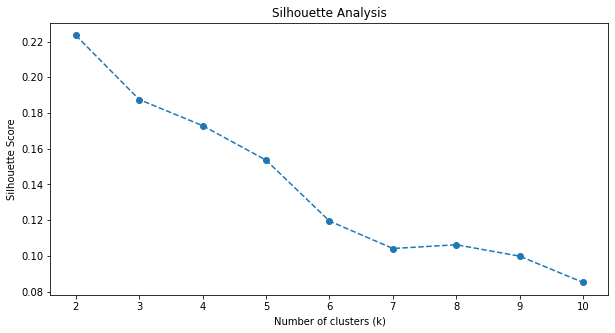

In [26]:
# to determine number of clusters not sure should be run this before weightage or after
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

silhouette_scores = []
for n_clusters in range(2, 11):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(combined_df)
    score = silhouette_score(combined_df, preds)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

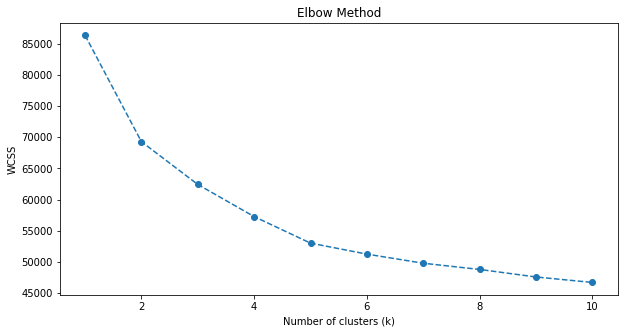

In [27]:
#same but with different method since all these method are heuritsic we might need to pick on certain assumptions
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS for a range of k values
wcss = []
for i in range(1, 11):  # Let's consider 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(combined_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()


In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# run clustering with user weights this is suppose to be coming from front end
weights = {
    'rating': 1.10,
    'acidity_structure': 1.10,
    'aftertaste': 1.10,
    'aroma': 1,
    'body': 1,
    'flavor': 1,
    'with_milk': 1,
    'price_category_High Price': 1.70
}
# Apply weights to the features in combined_df
for feature, weight in weights.items():
    combined_df[feature] = combined_df[feature] * weight

    
# Scale the entire DataFrame (including weighted and unweighted features)
scaler = StandardScaler()
combined_df_scaled = scaler.fit_transform(combined_df)

#  number of clusters (k)
n_clusters = 3  # Replace this with the number of clusters we would determined

# Perform K-Means clustering on the scaled data
# random state 42 being any random number 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_df_scaled)

# Add the cluster labels
df_cleaned['cluster'] = clusters

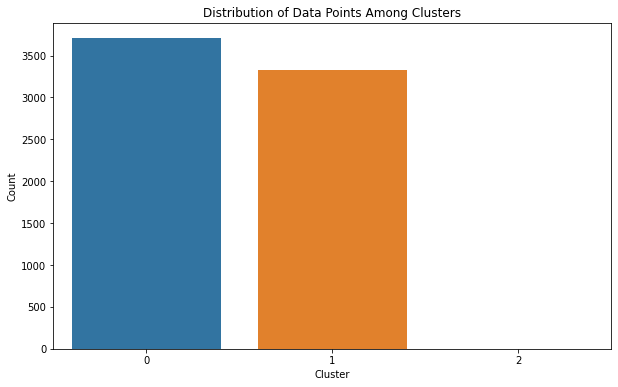

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_df' has a 'cluster' column with cluster labels
# Count plot of cluster assignments
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=combined_df)
plt.title('Distribution of Data Points Among Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

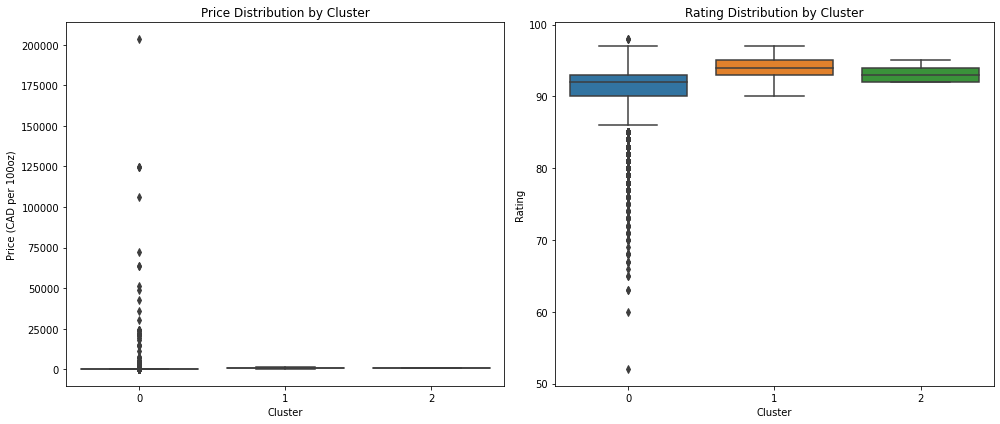

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Create a subplot for price
plt.subplot(1, 2, 1)
sns.boxplot(x='cluster', y='est_price_cad_per_100oz', data=df_cleaned)
plt.title('Price Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price (CAD per 100oz)')

# Create a subplot for rating
plt.subplot(1, 2, 2)
sns.boxplot(x='cluster', y='rating', data=df_cleaned)
plt.title('Rating Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Rating')

plt.tight_layout()
plt.show()


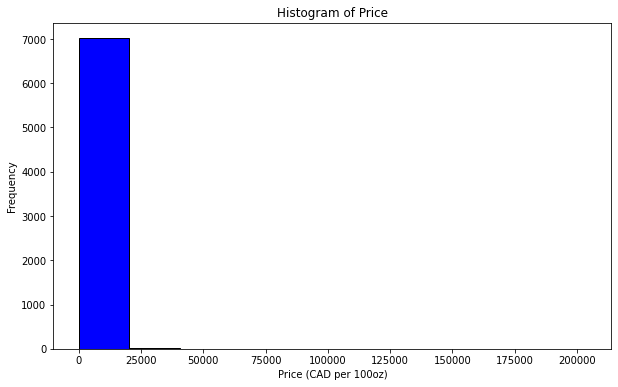

In [129]:
import matplotlib.pyplot as plt

# Assuming 'combined_df' is your DataFrame and 'est_price_cad_per_100oz' is the price column
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['est_price_cad_per_100oz'], color='blue', edgecolor='black')
plt.title('Histogram of Price')
plt.xlabel('Price (CAD per 100oz)')
plt.ylabel('Frequency')
plt.show()